In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

In [2]:
import tensorflow as tf

def sample(data, labels, num_samples_per_digit):
    sampled_data = []
    sampled_labels = []
    for digit in range(10):
        digit_indices = np.where(labels == digit)[0]
        sampled_indices = np.random.choice(digit_indices, num_samples_per_digit, replace=False)
        sampled_data.append(data[sampled_indices])
        sampled_labels.append(labels[sampled_indices])
    return np.concatenate(sampled_data), np.concatenate(sampled_labels)

# Keras CNN on un-augmented CIFAR10 data

In [3]:
from tensorflow.keras.datasets import cifar10

# Load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Define how many samples of each digit to include
train_samples_per_class = 100
test_samples_per_class = 100

# Sample the training and testing data
X_train, y_train = sample(X_train, y_train, train_samples_per_class)
X_test, y_test = sample(X_test, y_test, test_samples_per_class)

# Print shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape: ", X_test.shape)

X_train.shape: (1000, 32, 32, 3)
X_test.shape:  (1000, 32, 32, 3)


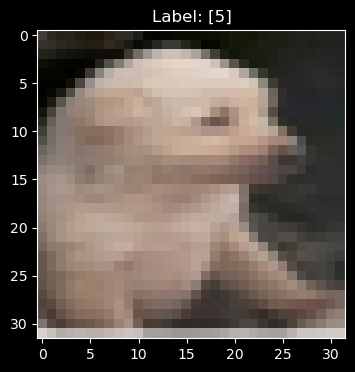

In [4]:
# Display a random image
idx = np.random.randint(0, len(X_train))
plt.figure(figsize=(4, 4))
plt.imshow(X_train[idx])
plt.title(f"Label: {y_train[idx]}")
plt.show()

In [5]:
# Resize and preprocess the data to match EfficientNetB3 input
X_train = np.array( tf.image.resize(X_train, (224, 224)) )
X_test = np.array( tf.image.resize(X_test, (224, 224)) )

print("X_train.shape:", X_train.shape)
print("X_test.shape: ", X_test.shape)

X_train.shape: (1000, 224, 224, 3)
X_test.shape:  (1000, 224, 224, 3)


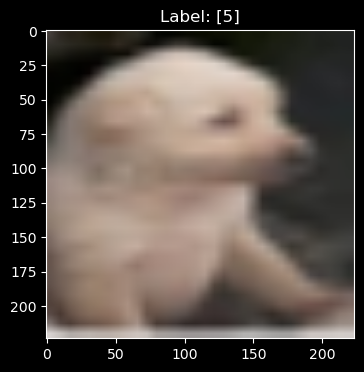

In [6]:
# Display a random image
plt.figure(figsize=(4, 4))
plt.imshow(X_train[idx].astype(int))
plt.title(f"Label: {y_train[idx]}")
plt.show()

## Load Model

Keras applications

https://keras.io/api/applications/

In [7]:
from tensorflow.keras.applications import EfficientNetV2M

# Load EfficientNetB3 without top layer
base_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Display model summary
#base_model.summary()

In [8]:
# Extract features using the untrainable EfficientNetB3
X_train_encoded = base_model.predict(X_train, verbose=1)
X_test_encoded = base_model.predict(X_test, verbose=1)

print("X_train_encoded.shape:", X_train_encoded.shape)
print("X_test_encoded.shape: ", X_test_encoded.shape)

32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step
X_train_encoded.shape: (1000, 7, 7, 1280)
X_test_encoded.shape:  (1000, 7, 7, 1280)


In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

dropout_rate = 0.5
n_classes  = np.unique(y_train).shape[0]

# Create a classification head
input_encoded = Input(shape=X_train_encoded.shape[1:])
x = GlobalAveragePooling2D()(input_encoded)
x = Dense(64, activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(n_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=input_encoded, outputs=outputs)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 7, 7, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,394 (329.66 KB)

 Trainable params: 84,394 (329.66 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay, PolynomialDecay

# define training parameters
epochs     = 50
batch_size = 200

optimizer = Adam(
    learning_rate=0.001,
)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=20,          # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

In [19]:
history = model.fit(
    X_train_encoded, y_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_test_encoded, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.1952 - loss: 2.2328 - val_accuracy: 0.5390 - val_loss: 1.9782
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4420 - loss: 1.9350 - val_accuracy: 0.7060 - val_loss: 1.6344
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5719 - loss: 1.6068 - val_accuracy: 0.7890 - val_loss: 1.2866
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6577 - loss: 1.3243 - val_accuracy: 0.8340 - val_loss: 0.9913
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7296 - loss: 1.0502 - val_accuracy: 0.8510 - val_loss: 0.7697
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7773 - loss: 0.8794 - val_accuracy: 0.8590 - val_loss: 0.6205
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8207 - loss: 0.7009 - val_accuracy: 0.8700 - val_loss: 0.5233
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8381 - loss: 0.6160 - val_accuracy: 0.8710 - val_loss: 0.4638


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


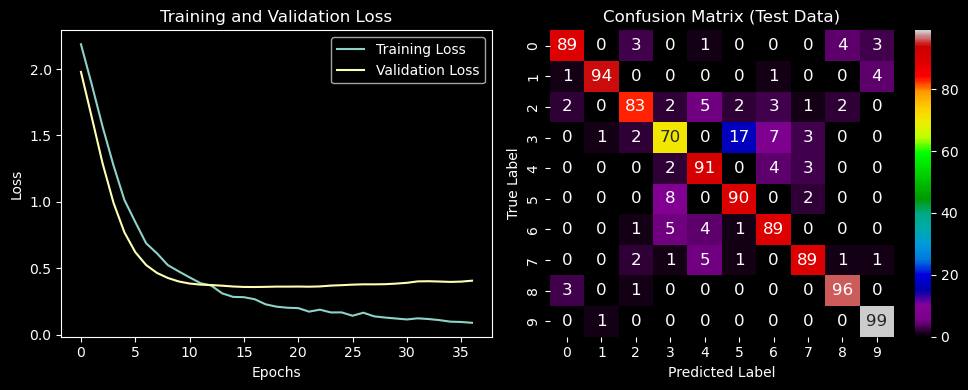

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       100
           1       0.98      0.94      0.96       100
           2       0.90      0.83      0.86       100
           3       0.80      0.70      0.74       100
           4       0.86      0.91      0.88       100
           5       0.81      0.90      0.85       100
           6       0.86      0.89      0.87       100
           7       0.91      0.89      0.90       100
           8       0.93      0.96      0.95       100
           9       0.93      0.99      0.96       100

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_test_pred  = model.predict(X_test_encoded).argmax(axis=1)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left subplot: Training and Validation Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
#axes[0].set_yscale('log')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Right subplot: Confusion Matrix (Test Data) using seaborn heatmap with vmin set to 0
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1], vmin=0, 
            annot_kws={"size": 12}, cmap='nipy_spectral')
axes[1].set_title('Confusion Matrix (Test Data)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Print classification report for test data
report = classification_report(y_test, y_test_pred)
print(report)

# Combined model

In [21]:
# Define the new input and pass through base_model
combined_input = Input(shape=(224, 224, 3))
x = base_model(combined_input, training=False)

# Now attach the existing classification head
x = model(x)

# Final combined model
combined_model = Model(inputs=combined_input, outputs=x)
combined_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-m (Functional)        │ (None, 7, 7, 1280)          │      53,150,388 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_2 (Functional)            │ (None, 10)                  │          84,394 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,234,782 (203.07 MB)

 Trainable params: 84,394 (329.66 KB)

 Non-trainable params: 53,150,388 (202.75 MB)

In [22]:
np.argmax(combined_model.predict(X_train[:10], verbose=1), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [23]:
y_train[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=uint8)